In [1]:
pip install -q -U keras-tuner


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
import keras
from keras import layers
import keras_tuner as kt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Preprocessing

In [3]:
data_dir = Path("/Captcha Dataset")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.jpg")))))
raw_labels = [img.split(os.path.sep)[-1].split(".jpg")[0] for img in images]
max_length = max([len(label) for label in raw_labels])
labels = [label.ljust(max_length) for label in raw_labels]
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 150
img_height = 30

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

# Mapping characters to integers
char_to_num = layers.StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = 1000
    val_samples = 100
    test_samples =100
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:train_samples+val_samples]], labels[indices[train_samples:train_samples+val_samples]]
    x_test, y_test = images[indices[train_samples+val_samples:]], labels[indices[train_samples+val_samples:]]
    return x_train, x_valid, x_test, y_train, y_valid, y_test


# Splitting data into training and validation sets
x_train, x_valid, x_test, y_train, y_valid, y_test = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}


Number of images found:  1200
Number of labels found:  1200
Number of unique characters:  32
Characters present:  [' ', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'j', 'k', 'm', 'n', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## Create `Dataset` objects

In [4]:

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = (
    test_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

## Visualize the data

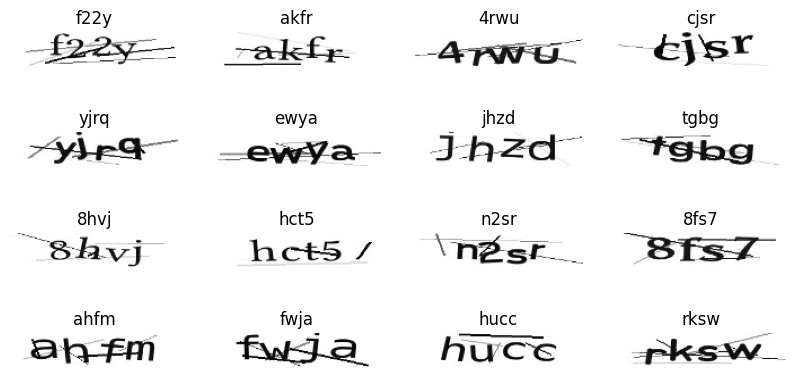

In [5]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

## Model

In [6]:
def ctc_batch_cost(y_true, y_pred, input_length, label_length):
    label_length = tf.cast(tf.squeeze(label_length, axis=-1), tf.int32)
    input_length = tf.cast(tf.squeeze(input_length, axis=-1), tf.int32)
    sparse_labels = tf.cast(ctc_label_dense_to_sparse(y_true, label_length), tf.int32)

    y_pred = tf.math.log(tf.transpose(y_pred, perm=[1, 0, 2]) + keras.backend.epsilon())

    return tf.expand_dims(
        tf.compat.v1.nn.ctc_loss(
            inputs=y_pred, labels=sparse_labels, sequence_length=input_length
        ),
        1,
    )


def ctc_label_dense_to_sparse(labels, label_lengths):
    label_shape = tf.shape(labels)
    num_batches_tns = tf.stack([label_shape[0]])
    max_num_labels_tns = tf.stack([label_shape[1]])

    def range_less_than(old_input, current_input):
        return tf.expand_dims(tf.range(tf.shape(old_input)[1]), 0) < tf.fill(
            max_num_labels_tns, current_input
        )

    init = tf.cast(tf.fill([1, label_shape[1]], 0), tf.bool)
    dense_mask = tf.compat.v1.scan(
        range_less_than, label_lengths, initializer=init, parallel_iterations=1
    )
    dense_mask = dense_mask[:, 0, :]

    label_array = tf.reshape(
        tf.tile(tf.range(0, label_shape[1]), num_batches_tns), label_shape
    )
    label_ind = tf.compat.v1.boolean_mask(label_array, dense_mask)

    batch_array = tf.transpose(
        tf.reshape(
            tf.tile(tf.range(0, label_shape[0]), max_num_labels_tns),
            tf.reverse(label_shape, [0]),
        )
    )
    batch_ind = tf.compat.v1.boolean_mask(batch_array, dense_mask)
    indices = tf.transpose(
        tf.reshape(tf.concat([batch_ind, label_ind], axis=0), [2, -1])
    )

    vals_sparse = tf.compat.v1.gather_nd(labels, indices)

    return tf.SparseTensor(
        tf.cast(indices, tf.int64), vals_sparse, tf.cast(label_shape, tf.int64)
    )


class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [7]:
def build_model(hp):
    
    hp_filter_1 = hp.Choice('filter_1', values=[16,32,64,128])
    hp_filter_2 = hp.Choice('filter_2', values=[16,32,64,128])
    hp_filter_3 = hp.Choice('filter_3', values=[16,32,64,128])
    hp_filter_4 = hp.Choice('filter_4', values=[16,32,64,128])
    hp_dense_1 = hp.Choice('dense_1', values=[16,32,64,128])
    hp_lstm_1 = hp.Choice('lstm_1', values=[16,32,64,128])



    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        hp_filter_1,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.BatchNormalization()(x)

    # Second conv block
    x = layers.Conv2D(
        hp_filter_2,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)    
    
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    x = layers.BatchNormalization()(x)

    # Third conv block
    x = layers.Conv2D(
        hp_filter_3,
        (1, 1),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv3",
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(
        hp_filter_4,
        (1, 1),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv4",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)
   
    new_shape = ((img_width // 4), (img_height // 4) * hp_filter_4)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(hp_dense_1, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.25)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(hp_lstm_1, return_sequences=True, dropout=0.25))(x)
    
    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense3"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


## Training

In [8]:
tuner = kt.Hyperband(build_model,
                     objective='val_loss',
                     max_epochs=200,
                     factor=3,
                     directory='paus_captcha',
                     project_name='version_2')

In [9]:

# TODO restore epoch count.
epochs = 200
early_stopping_patience = 15
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)


# Train the model
tuner.search(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)



Trial 254 Complete [00h 01m 58s]
val_loss: 12.702096939086914

Best val_loss So Far: 0.4404800534248352
Total elapsed time: 02h 20m 21s


In [10]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/200
63/63 [==============================] - 11s 44ms/step - loss: 18.5631 - val_loss: 15.3130
Epoch 2/200
63/63 [==============================] - 1s 21ms/step - loss: 15.1855 - val_loss: 15.2442
Epoch 3/200
63/63 [==============================] - 1s 21ms/step - loss: 15.1648 - val_loss: 15.2372
Epoch 4/200
63/63 [==============================] - 1s 21ms/step - loss: 15.1273 - val_loss: 15.2428
Epoch 5/200
63/63 [==============================] - 1s 21ms/step - loss: 15.0781 - val_loss: 15.2020
Epoch 6/200
63/63 [==============================] - 1s 22ms/step - loss: 14.9898 - val_loss: 15.1560
Epoch 7/200
63/63 [==============================] - 1s 22ms/step - loss: 14.8995 - val_loss: 15.1142
Epoch 8/200
63/63 [==============================] - 1s 22ms/step - loss: 14.7948 - val_loss: 15.0532
Epoch 9/200
63/63 [==============================] - 1s 21ms/step - loss: 14.5943 - val_loss: 14.8870
Epoch 10/200
63/63 [==============================] - 1s 21ms/step - loss: 14.350

In [11]:
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 150, 30, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 150, 30, 128)         1280      ['image[0][0]']               
                                                                                                  
 batch_normalization_3 (Bat  (None, 150, 30, 128)         512       ['Conv1[0][0]']               
 chNormalization)                                                                                 
                                                                                                  
 Conv2 (Conv2D)              (None, 150, 30, 16)          18448     ['batch_normalizati

## Inference

You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/ocr-for-captcha)
and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/ocr-for-captcha).

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 150, 30, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 150, 30, 128)      1280      
                                                                 
 batch_normalization_3 (Bat  (None, 150, 30, 128)      512       
 chNormalization)                                                
                                                                 
 Conv2 (Conv2D)              (None, 150, 30, 16)       18448     
                                                                 
 pool1 (MaxPooling2D)        (None, 75, 15, 16)        0         
                                                                 
 batch_normalization_4 (Bat  (None, 75, 15, 16)        64        
 chNormalization)                                            

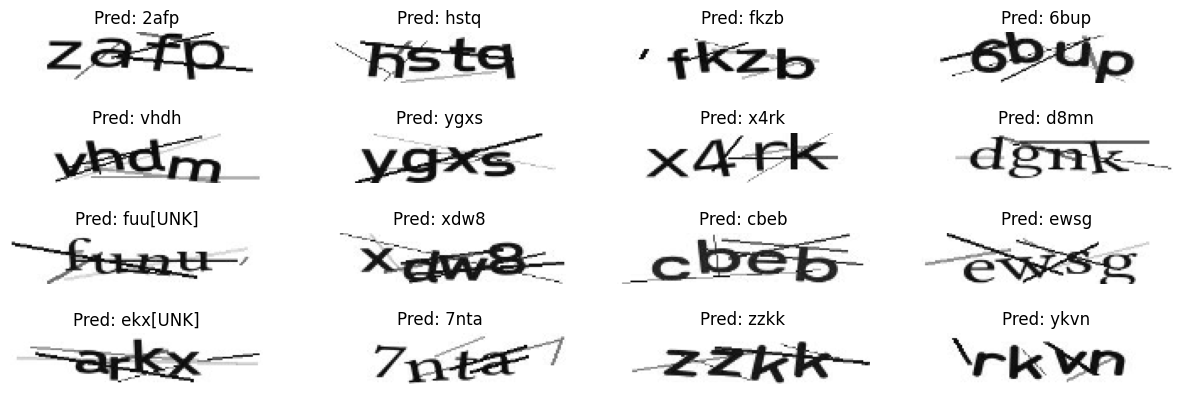

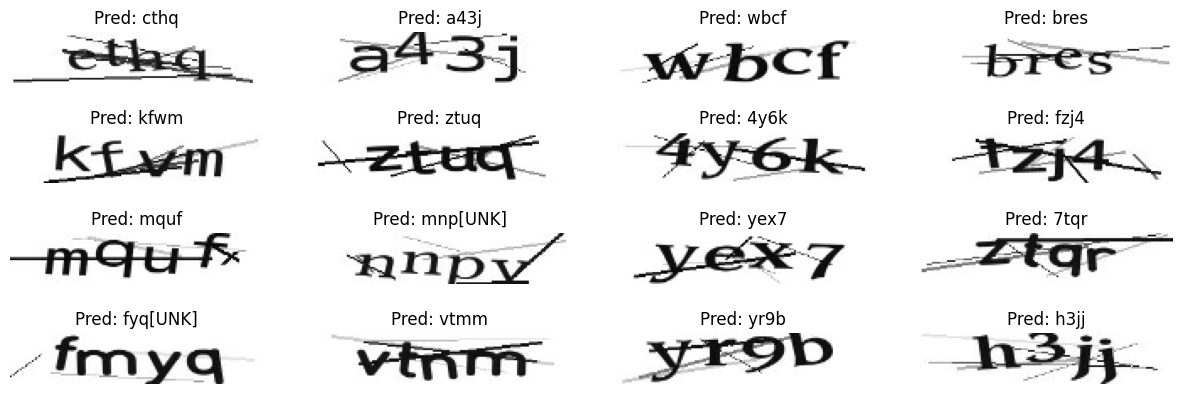

In [12]:

def ctc_decode(y_pred, input_length, greedy=True, beam_width=100, top_paths=1):
    input_shape = tf.shape(y_pred)
    num_samples, num_steps = input_shape[0], input_shape[1]
    y_pred = tf.math.log(tf.transpose(y_pred, perm=[1, 0, 2]) + keras.backend.epsilon())
    input_length = tf.cast(input_length, tf.int32)

    if greedy:
        (decoded, log_prob) = tf.nn.ctc_greedy_decoder(
            inputs=y_pred, sequence_length=input_length
        )
    else:
        (decoded, log_prob) = tf.compat.v1.nn.ctc_beam_search_decoder(
            inputs=y_pred,
            sequence_length=input_length,
            beam_width=beam_width,
            top_paths=top_paths,
        )
    decoded_dense = []
    for st in decoded:
        st = tf.SparseTensor(st.indices, st.values, (num_samples, num_steps))
        decoded_dense.append(tf.sparse.to_dense(sp_input=st, default_value=-1))
    return (decoded_dense, log_prob)


# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.input[0], model.get_layer(name="dense3").output
)
prediction_model.summary()


# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in test_dataset.take(2):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Pred: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [13]:
model.evaluate(train_dataset)

63/63 [==============================] - 1s 13ms/step - loss: 0.1104


0.11037547141313553

In [14]:
model.evaluate(validation_dataset)

7/7 [==============================] - 0s 11ms/step - loss: 1.8102


1.810197353363037

In [15]:
model.evaluate(test_dataset)

7/7 [==============================] - 0s 12ms/step - loss: 1.7203


1.720293402671814

In [16]:
pred_test = []
label_test = []


for batch in train_dataset:
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images, verbose=0)
    pred_texts = decode_batch_predictions(preds)

    for pred in pred_texts:
        pred_test.append(pred.replace("[UNK]", " "))
    for label in batch_labels:
        label_test.append(tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8"))

        
sum = 0
for pred, label in zip(pred_test, label_test):
    sum = sum + [ai == bi for ai,bi in zip([*pred],[*label])].count(True)
    
print(sum/((len(pred_test)*4)))

0.99575


In [17]:
pred_test = []
label_test = []


for batch in validation_dataset:
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images, verbose=0)
    pred_texts = decode_batch_predictions(preds)

    for pred in pred_texts:
        pred_test.append(pred.replace("[UNK]", " "))
    for label in batch_labels:
        label_test.append(tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8"))

        
sum = 0
for pred, label in zip(pred_test, label_test):
    sum = sum + [ai == bi for ai,bi in zip([*pred],[*label])].count(True)
    
print(sum/((len(pred_test)*4)))

0.83


In [18]:
pred_test = []
label_test = []


for batch in test_dataset:
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images, verbose=0)
    pred_texts = decode_batch_predictions(preds)

    for pred in pred_texts:
        pred_test.append(pred.replace("[UNK]", " "))
    for label in batch_labels:
        label_test.append(tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8"))

        
sum = 0
for pred, label in zip(pred_test, label_test):
    sum = sum + [ai == bi for ai,bi in zip([*pred],[*label])].count(True)
    
print(sum/((len(pred_test)*4)))

0.8425
